In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from keras import backend as K
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.applications import resnet
from keras.applications.vgg16 import VGG16
from keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
base_path = 'E:/DATASET EXPERIMENT/Resize exp'

In [3]:
SIZE = 224
image_size = (SIZE, SIZE)
batch_size = 32
channels = 3
kernel = 4
stride = 1
pool = 2

(224, 224, 3)


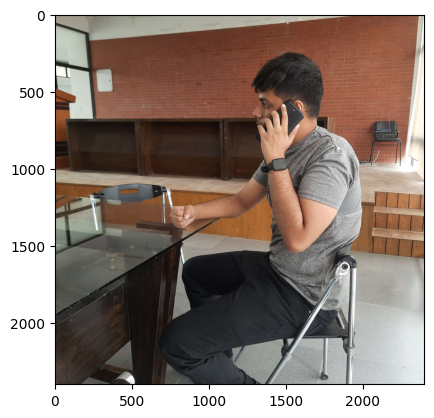

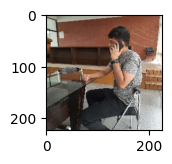

In [4]:
#show resized images
img = cv2.imread("E:/DATASET EXPERIMENT/Resize/Calling/20240425_085451 (resize).jpg")[:, :, ::-1]
width, height = SIZE, SIZE
resized_img = cv2.resize(img, (width, height))
plt.imshow(img)
plt.figure(figsize = (1.5, 1.5))
plt.imshow(resized_img)
print(resized_img.shape)

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)

Found 2500 files belonging to 10 classes.
Using 2000 files for training.
Found 2500 files belonging to 10 classes.
Using 500 files for validation.


In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip= True,
    vertical_flip= False,
    validation_split= 0.2,
)
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split= 0.2,
)

In [7]:
train_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'training'
)
test_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = False,
    subset = 'validation'
)

Found 2000 images belonging to 10 classes.


Found 500 images belonging to 10 classes.


In [8]:
test_set.class_indices

{'Calling': 0,
 'Cheating': 1,
 'Climbing': 2,
 'Consuming': 3,
 'LisentingMusic': 4,
 'Sitting': 5,
 'Standing': 6,
 'Studying': 7,
 'Talking': 8,
 'Teaching': 9}

In [9]:
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['Calling',
 'Cheating',
 'Climbing',
 'Consuming',
 'LisentingMusic',
 'Sitting',
 'Standing',
 'Studying',
 'Talking',
 'Teaching']

In [10]:
labels = ['Calling','Cheating','Climbing','Consuming','LisentingMusic','Sitting','Standing','Studying','Talking','Teaching']

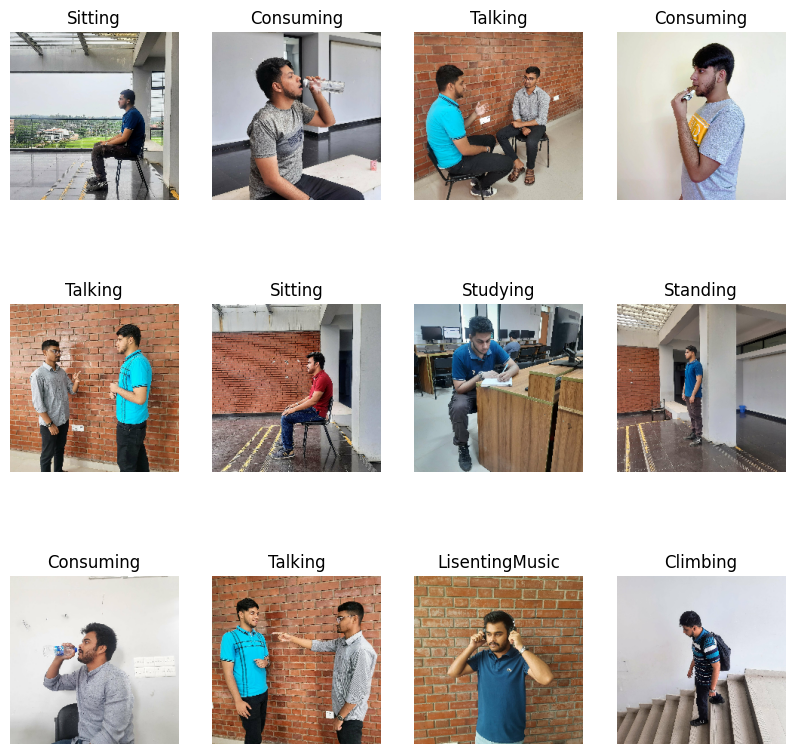

In [11]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in train_ds.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

#CNN Model


In [13]:
model=Sequential()

model.add(Conv2D(16,kernel_size=kernel,strides=stride,padding='same',activation='relu',input_shape=(SIZE, SIZE, channels)))
model.add(MaxPool2D(pool_size=pool,strides=2,padding='same'))
Dropout(0.25),
model.add(Conv2D(32,kernel_size=kernel,strides=stride,activation='relu',padding='same'))
model.add(MaxPool2D((pool),2,padding='same'))
Dropout(0.25),
model.add(Conv2D(64,kernel_size=kernel,strides=stride,activation='relu',padding='same'))
model.add(MaxPool2D((pool),2,padding='same'))
Dropout(0.25),
model.add(Flatten())

model.add(Dense(units=128,activation='relu'))
Dropout(0.25),
model.add(Dense(units=num_classes,activation='softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 16)   │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 32)   │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,465,786 (24.67 MB)

 Trainable params: 6,465,786 (24.67 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit( train_set, epochs=25, validation_data=test_set)

Epoch 1/25


c:\Users\mouat\anaconda3\envs\py310\lib\site-packages\keras\src\backend\tensorflow\nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
c:\Users\mouat\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.1867 - loss: 2.3324 - val_accuracy: 0.4660 - val_loss: 1.5951
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6536 - loss: 0.9968 - val_accuracy: 0.6400 - val_loss: 1.0768
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7990 - loss: 0.6191 - val_accuracy: 0.6780 - val_loss: 0.9640
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8619 - loss: 0.4080 - val_accuracy: 0.7000 - val_loss: 0.8640
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9015 - loss: 0.3034 - val_accuracy: 0.7820 - val_loss: 0.8831
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9194 - loss: 0.2629 - val_accuracy: 0.8080 - val_loss: 0.6003
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9349 - loss: 0.1690 - val_accuracy: 0.8260 - val_loss: 0.6098
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9456 - loss: 0.1651 - val_accuracy: 0.8620 - val_loss: 0.5356
Ep

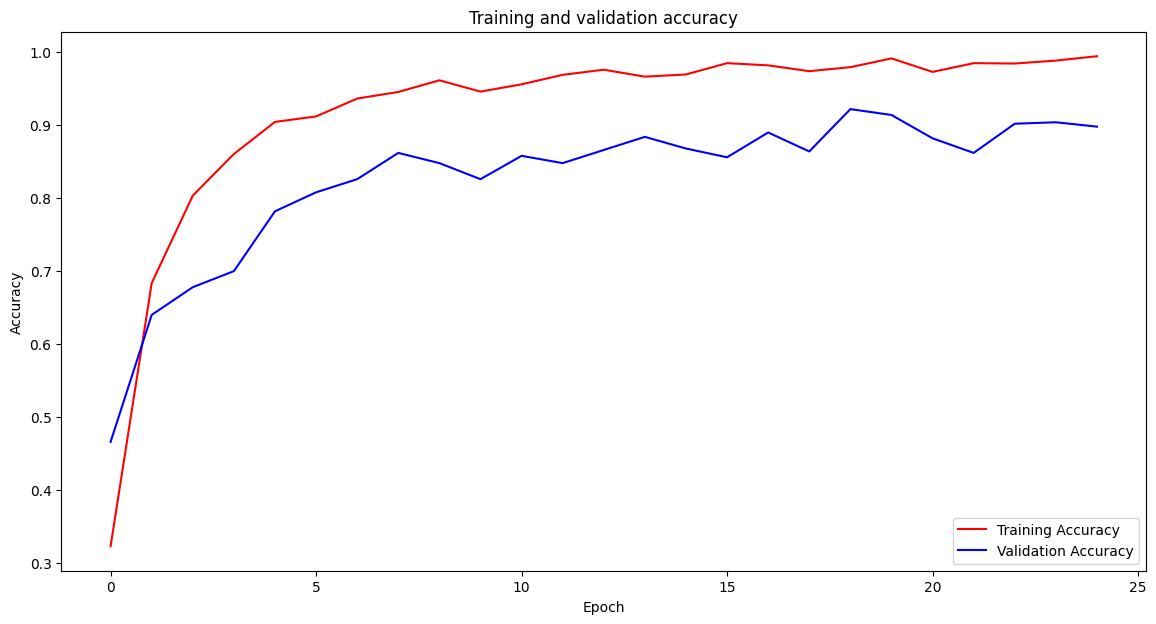

In [16]:
# Validation and Training accuracy plot
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

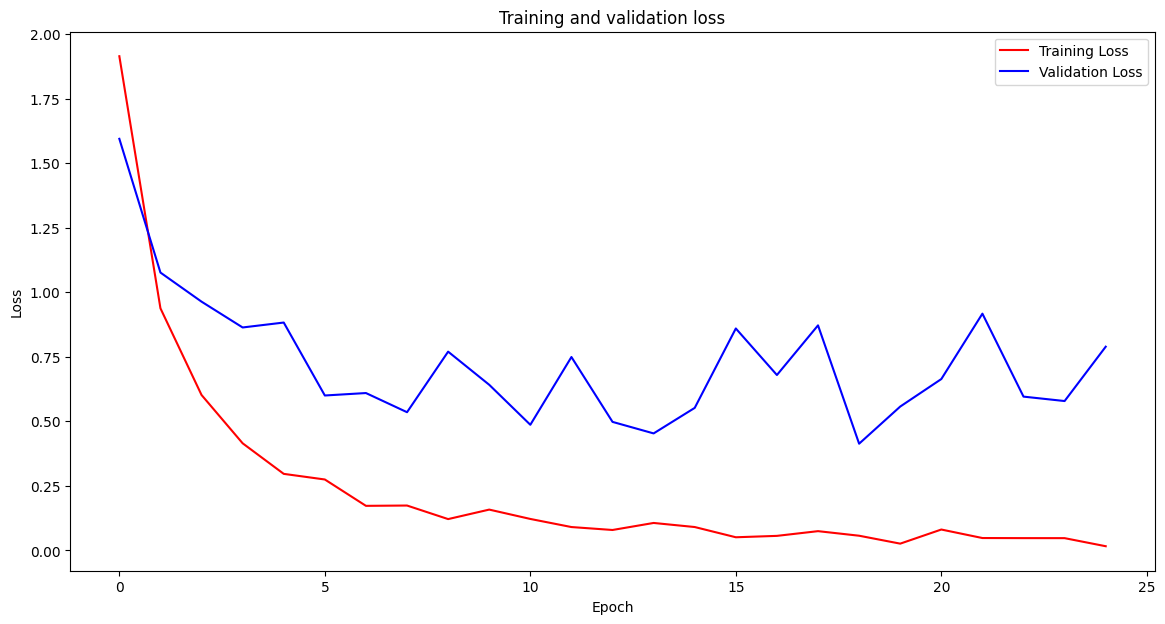

In [17]:
#Validation and Training loss plot
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [18]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


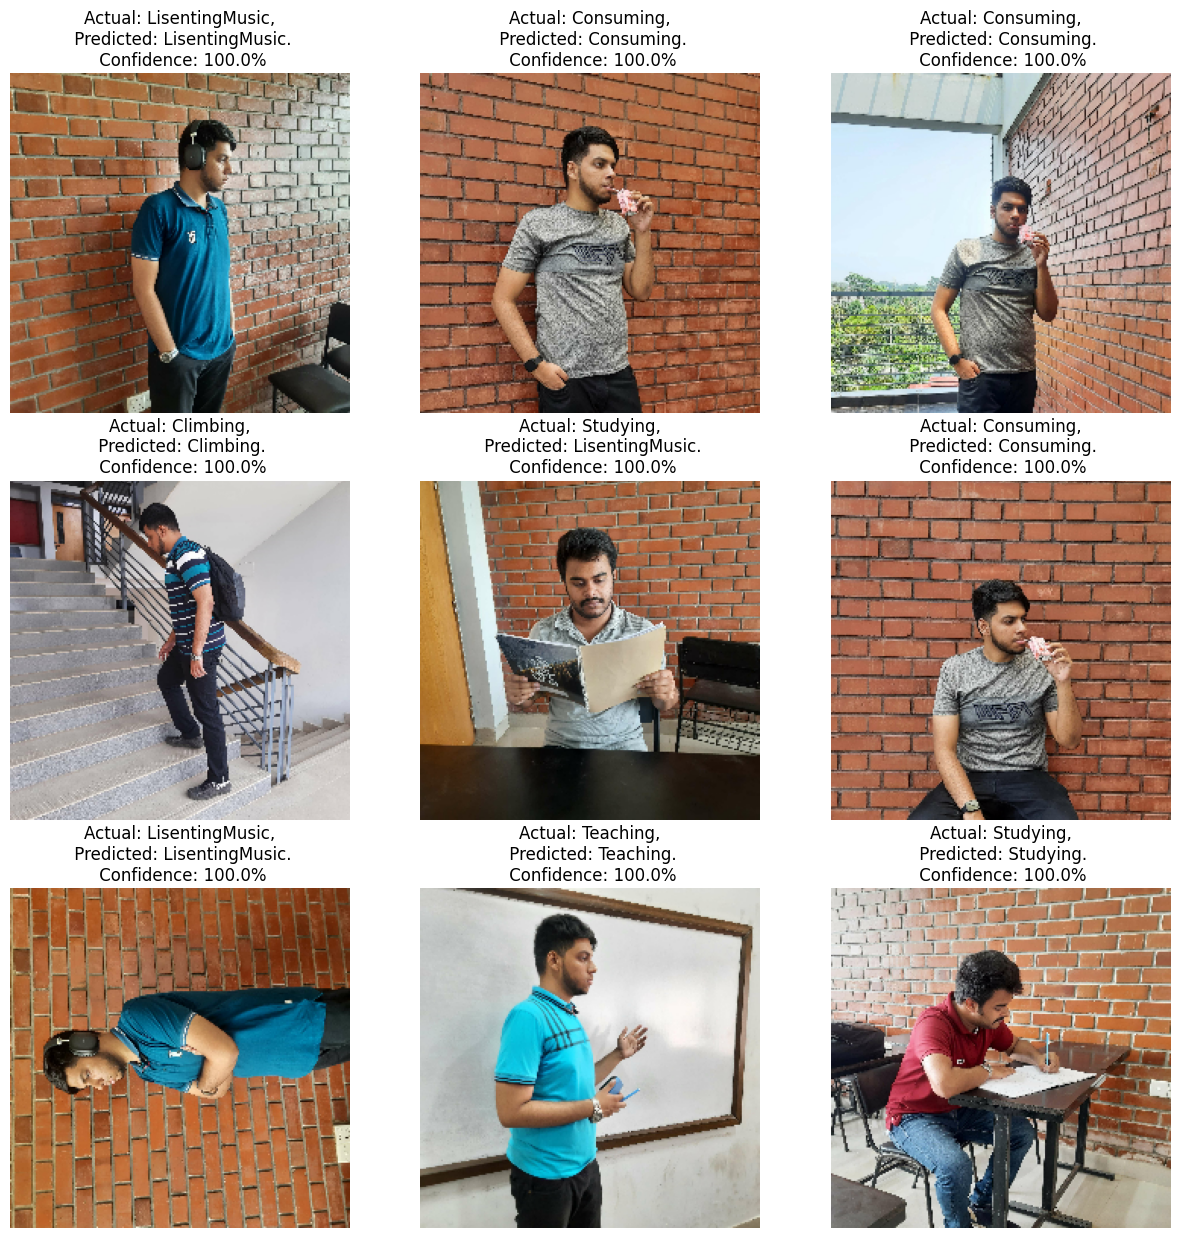

In [19]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        predicted_class, confidence =predict(model, image_batch[i].numpy())
        actual_class = class_names[labels_batch[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [20]:
loss,test_accuracy = model.evaluate(test_set)
print('Accuracy on test:', test_accuracy)
print('Loss on test set:', loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 927ms/step - accuracy: 0.7730 - loss: 2.0438
Accuracy on test: 0.8960000276565552
Loss on test set: 0.8199673891067505


In [21]:
# T0 print the Classification Report
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_set.classes, y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 934ms/step
              precision    recall  f1-score   support

           0       1.00      0.62      0.77        50
           1       1.00      0.72      0.84        50
           2       1.00      1.00      1.00        50
           3       0.94      0.92      0.93        50
           4       0.96      0.88      0.92        50
           5       0.89      0.96      0.92        50
           6       0.93      1.00      0.96        50
           7       0.72      0.98      0.83        50
           8       1.00      0.98      0.99        50
           9       0.79      1.00      0.88        50

    accuracy                           0.91       500
   macro avg       0.92      0.91      0.90       500
weighted avg       0.92      0.91      0.90       500



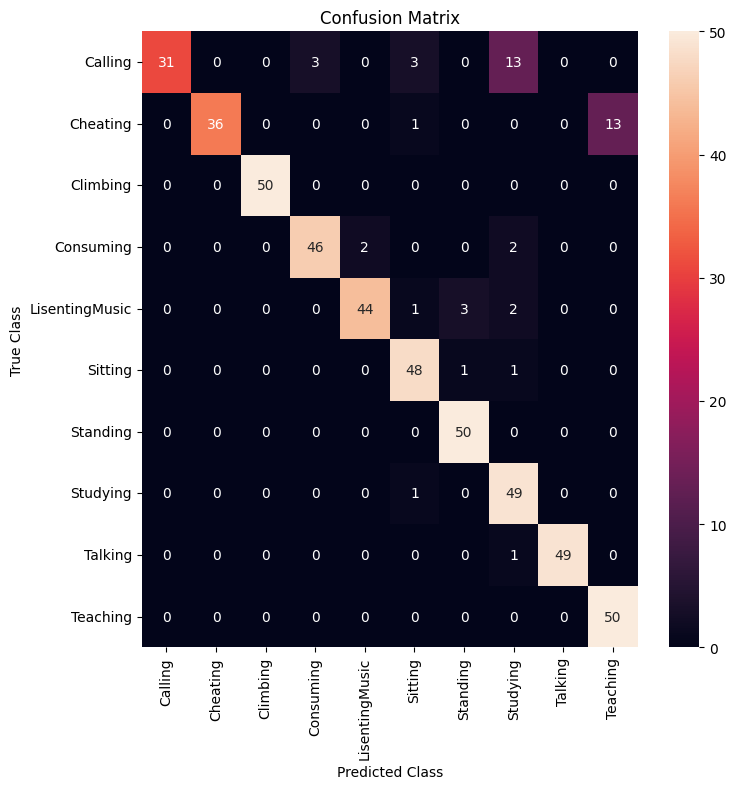

In [22]:
import seaborn as sns
# To print the Confusion Matrix
cf_matrix = confusion_matrix(test_set.classes, y_pred)
labels = ['Calling','Cheating','Climbing','Consuming','LisentingMusic','Sitting','Standing','Studying','Talking','Teaching']
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(cf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

Found 2500 images belonging to 10 classes.
Fold 1
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Epoch 1/25


c:\Users\mouat\anaconda3\envs\py310\lib\site-packages\keras\src\backend\tensorflow\nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
c:\Users\mouat\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 876ms/step - accuracy: 0.1506 - loss: 2.9470 - val_accuracy: 0.3260 - val_loss: 1.8348
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 852ms/step - accuracy: 0.4693 - loss: 1.5559 - val_accuracy: 0.4720 - val_loss: 1.5129
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 854ms/step - accuracy: 0.6739 - loss: 0.9887 - val_accuracy: 0.5600 - val_loss: 1.1746
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 856ms/step - accuracy: 0.7526 - loss: 0.7411 - val_accuracy: 0.5460 - val_loss: 1.2061
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 856ms/step - accuracy: 0.8077 - loss: 0.5461 - val_accuracy: 0.6080 - val_loss: 1.1527
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 851ms/step - accuracy: 0.8376 - loss: 0.4581 - val_accuracy: 0.5960 - val_loss: 1.2203
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 856ms/step - accuracy: 0.8811 - loss: 0.3796 - val_accuracy: 0.5900 - val_loss: 1.1409
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 846ms/step - accuracy: 0.8942 - loss: 0.3122 - val_accuracy: 0.644

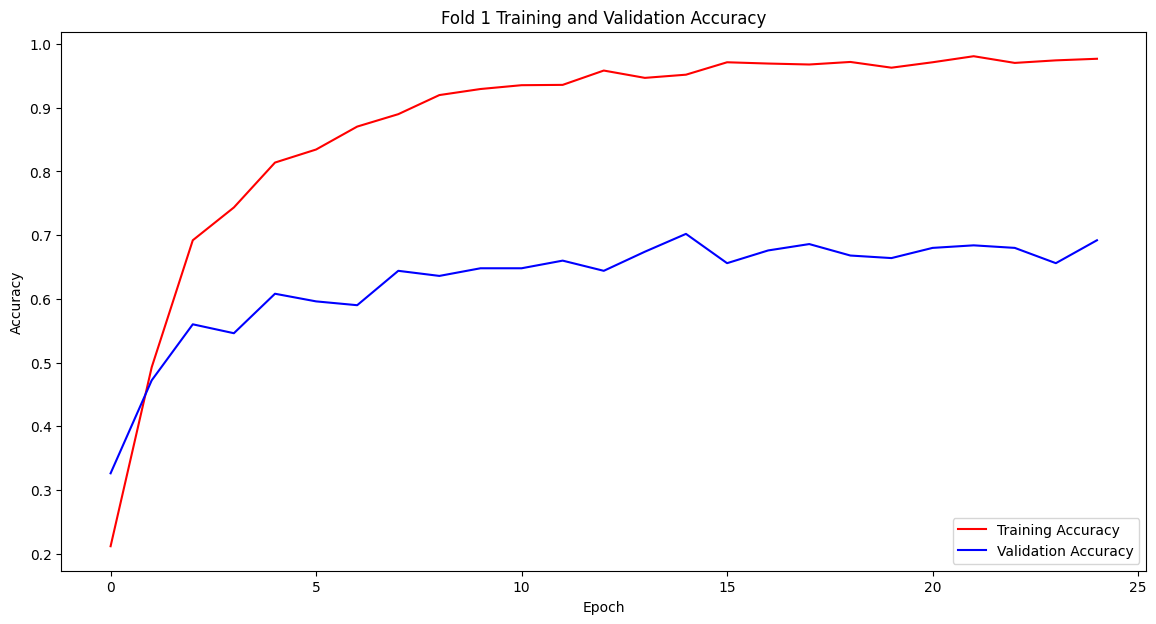

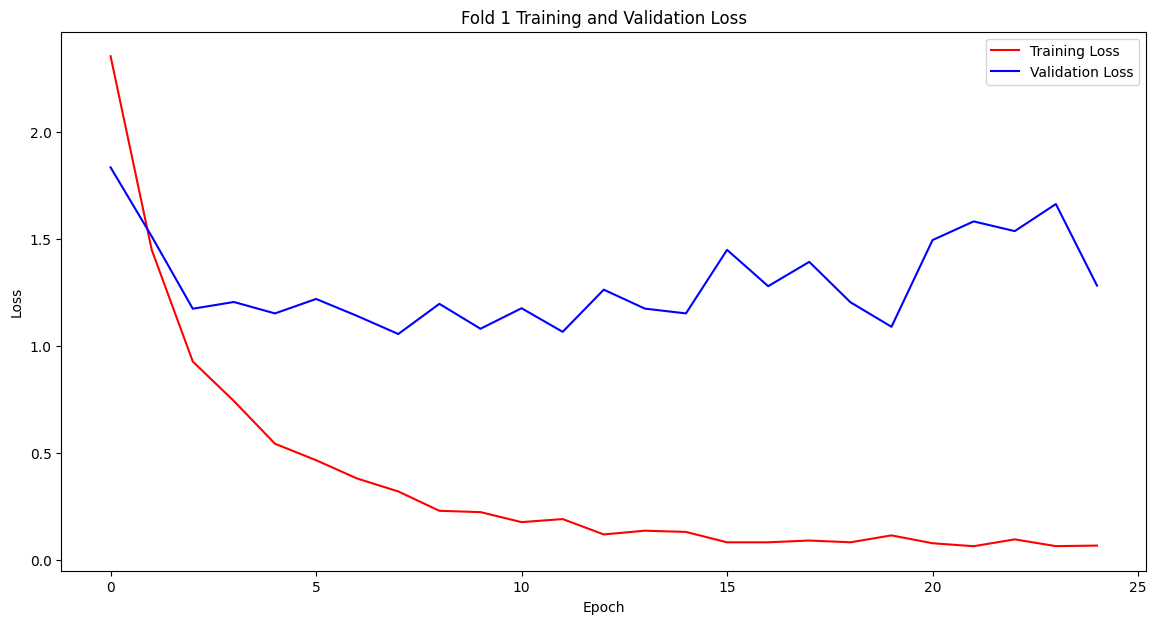

Score for fold 1: loss of 1.282970666885376; compile_metrics of 69.19999718666077%
Fold 2
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 870ms/step - accuracy: 0.1368 - loss: 3.5165 - val_accuracy: 0.2680 - val_loss: 2.1310
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 863ms/step - accuracy: 0.3434 - loss: 1.9119 - val_accuracy: 0.4600 - val_loss: 1.6440
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 847ms/step - accuracy: 0.5452 - loss: 1.3515 - val_accuracy: 0.5200 - val_loss: 1.4547
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 841ms/step - accuracy: 0.6638 - loss: 0.9886 - val_accuracy: 0.5600 - val_loss: 1.3540
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 855ms/step - accuracy: 0.7193 - loss: 0.7837 - val_accuracy: 0.5560 - val_loss: 1.3396
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 852ms/step - accuracy: 0.7863 - loss: 0.6166 - val_accuracy: 0.5720 - val_loss: 1.4202
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 843ms/ste

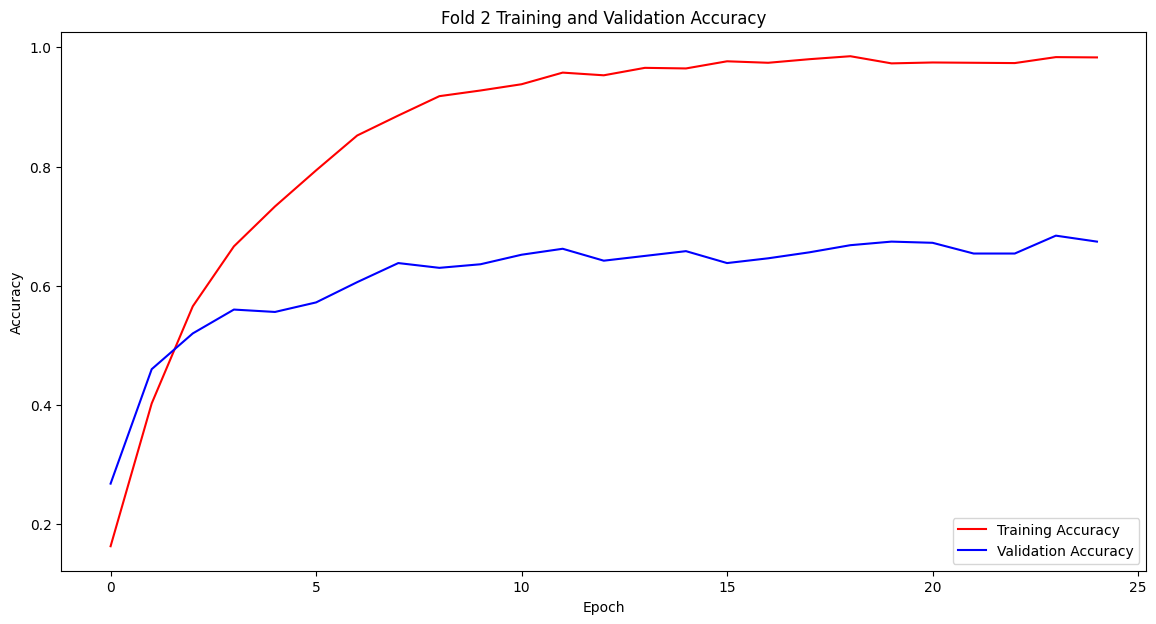

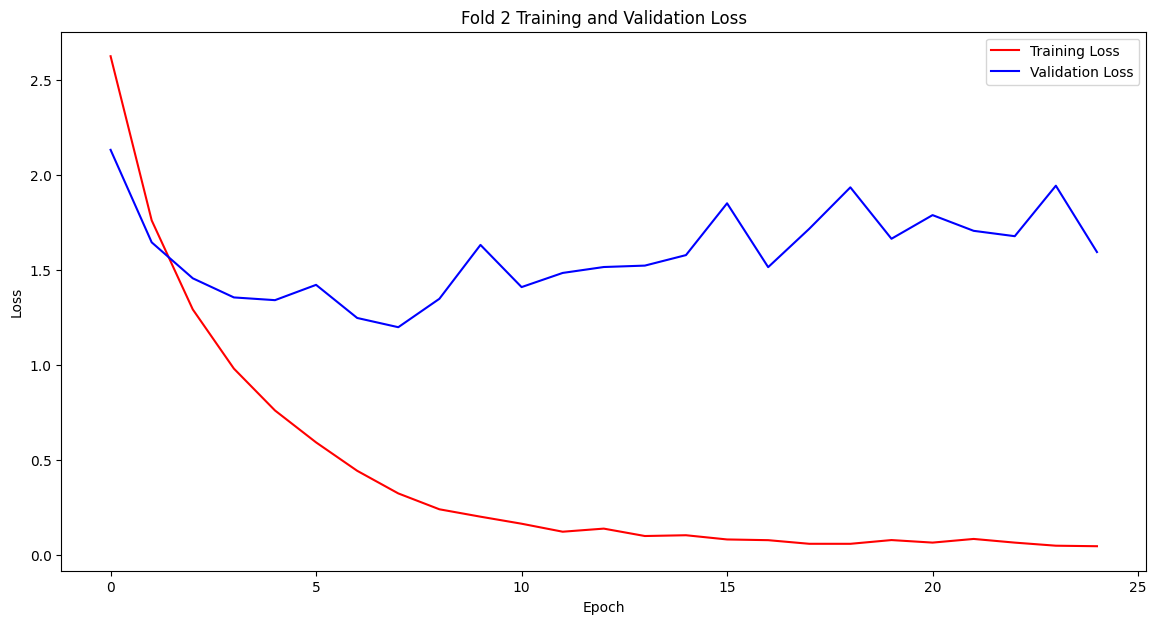

Score for fold 2: loss of 1.5928934812545776; compile_metrics of 67.40000247955322%
Fold 3
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 860ms/step - accuracy: 0.1006 - loss: 3.0019 - val_accuracy: 0.1960 - val_loss: 2.2885
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 844ms/step - accuracy: 0.1916 - loss: 2.1871 - val_accuracy: 0.3280 - val_loss: 1.8764
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 858ms/step - accuracy: 0.4780 - loss: 1.5258 - val_accuracy: 0.4460 - val_loss: 1.5565
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 861ms/step - accuracy: 0.6699 - loss: 0.9400 - val_accuracy: 0.5460 - val_loss: 1.3736
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 873ms/step - accuracy: 0.7751 - loss: 0.6594 - val_accuracy: 0.5820 - val_loss: 1.2086
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 869ms/step - accuracy: 0.8479 - loss: 0.4910 - val_accuracy: 0.5700 - val_loss: 1.2789
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 880ms/st

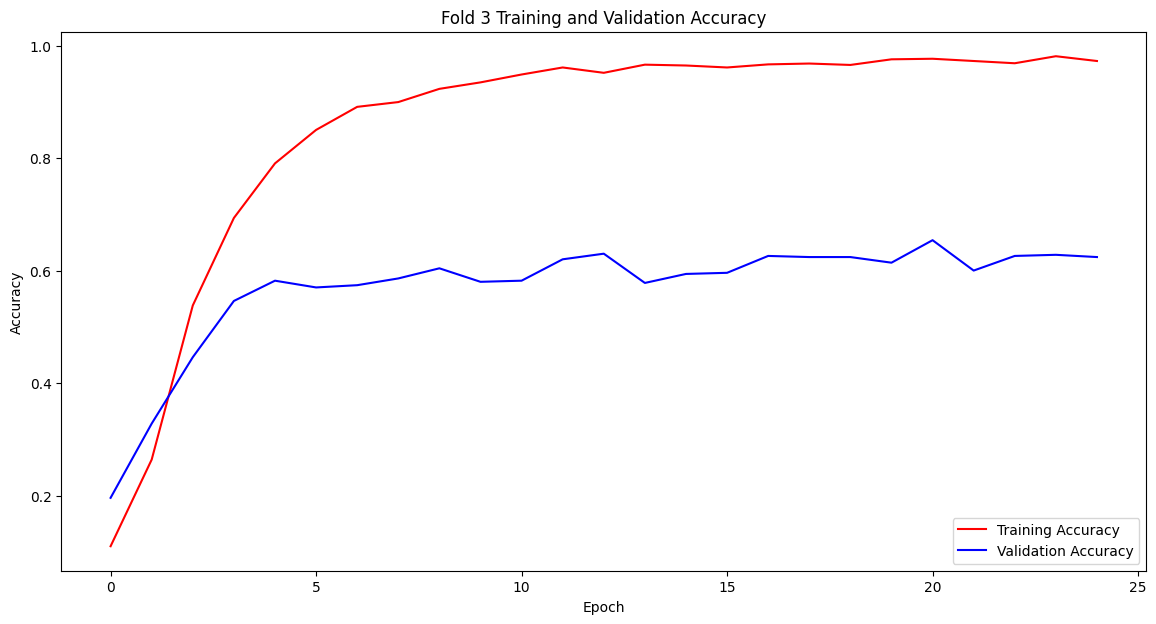

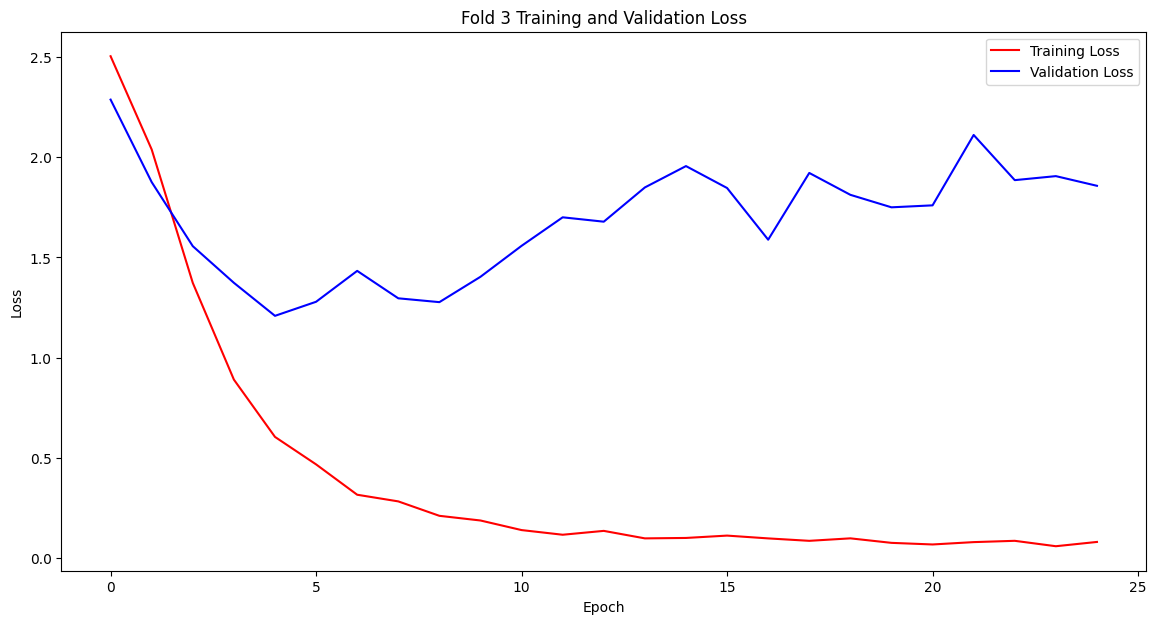

Score for fold 3: loss of 1.8580650091171265; compile_metrics of 62.40000128746033%
Fold 4
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 862ms/step - accuracy: 0.1170 - loss: 3.2197 - val_accuracy: 0.2740 - val_loss: 2.1898
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 847ms/step - accuracy: 0.3502 - loss: 1.8266 - val_accuracy: 0.4720 - val_loss: 1.5037
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 848ms/step - accuracy: 0.6125 - loss: 1.1186 - val_accuracy: 0.5420 - val_loss: 1.3023
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 843ms/step - accuracy: 0.7552 - loss: 0.7431 - val_accuracy: 0.5880 - val_loss: 1.1823
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 849ms/step - accuracy: 0.8074 - loss: 0.5625 - val_accuracy: 0.5660 - val_loss: 1.3189
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 844ms/step - accuracy: 0.8697 - loss: 0.3825 - val_accuracy: 0.5820 - val_loss: 1.3098
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 843ms/st

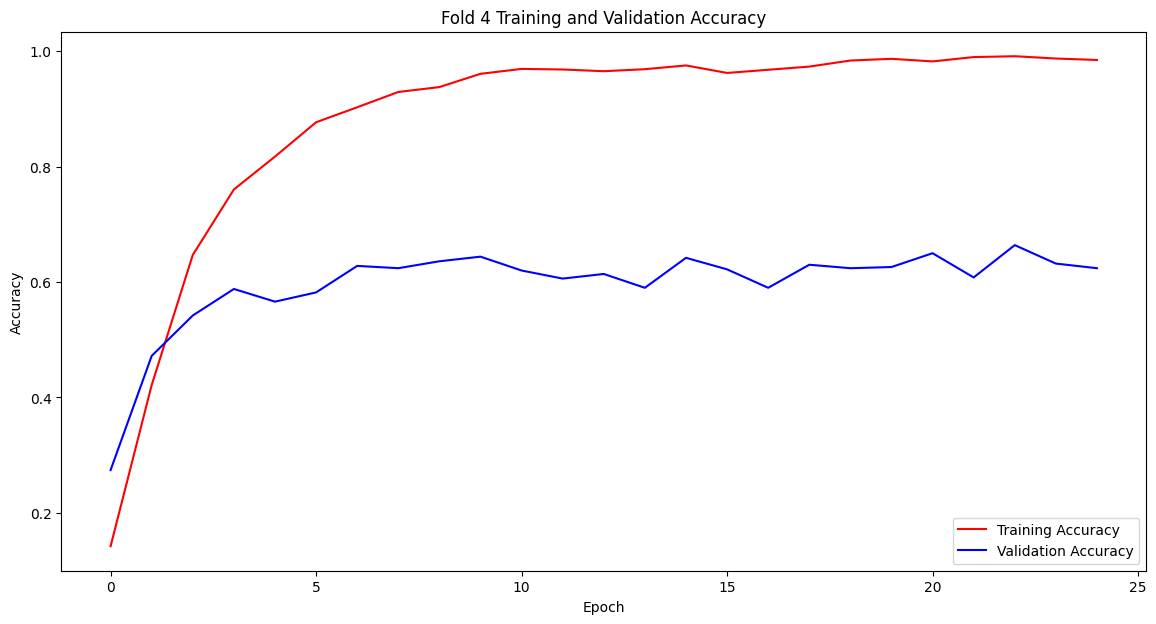

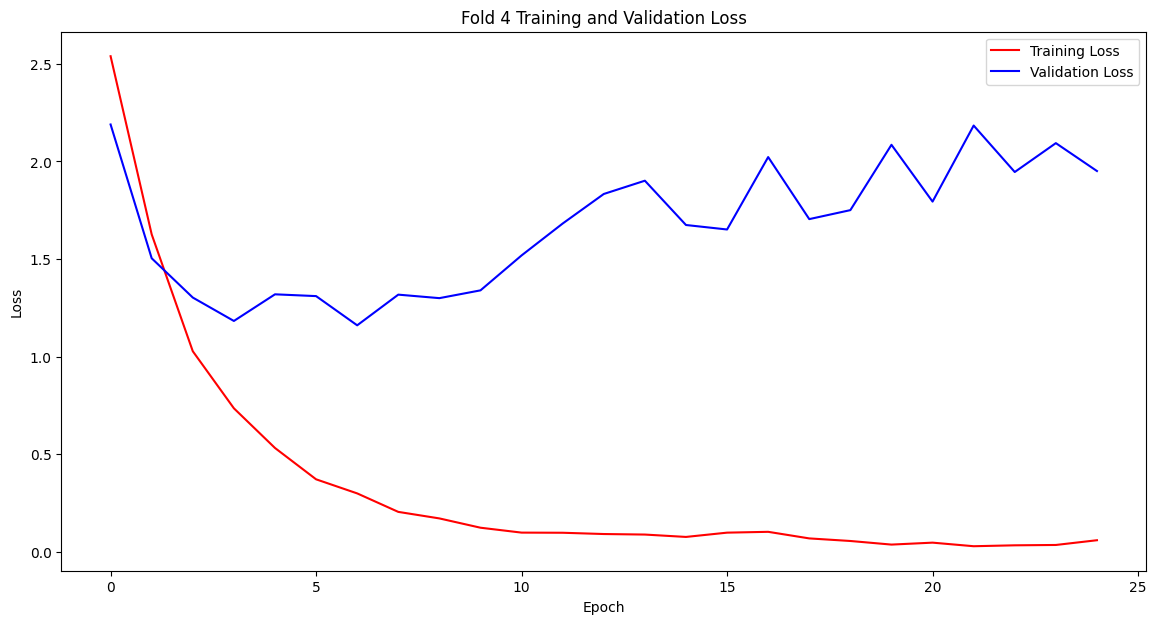

Score for fold 4: loss of 1.951101541519165; compile_metrics of 62.40000128746033%
Fold 5
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 879ms/step - accuracy: 0.1198 - loss: 3.0917 - val_accuracy: 0.3140 - val_loss: 2.0640
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 871ms/step - accuracy: 0.3682 - loss: 1.7792 - val_accuracy: 0.5080 - val_loss: 1.4937
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 865ms/step - accuracy: 0.6411 - loss: 1.0449 - val_accuracy: 0.6000 - val_loss: 1.1257
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 845ms/step - accuracy: 0.7480 - loss: 0.7578 - val_accuracy: 0.6480 - val_loss: 1.0018
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 866ms/step - accuracy: 0.8163 - loss: 0.5245 - val_accuracy: 0.6540 - val_loss: 1.0261
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 871ms/step - accuracy: 0.8548 - loss: 0.4218 - val_accuracy: 0.6280 - val_loss: 1.1617
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 872ms/ste

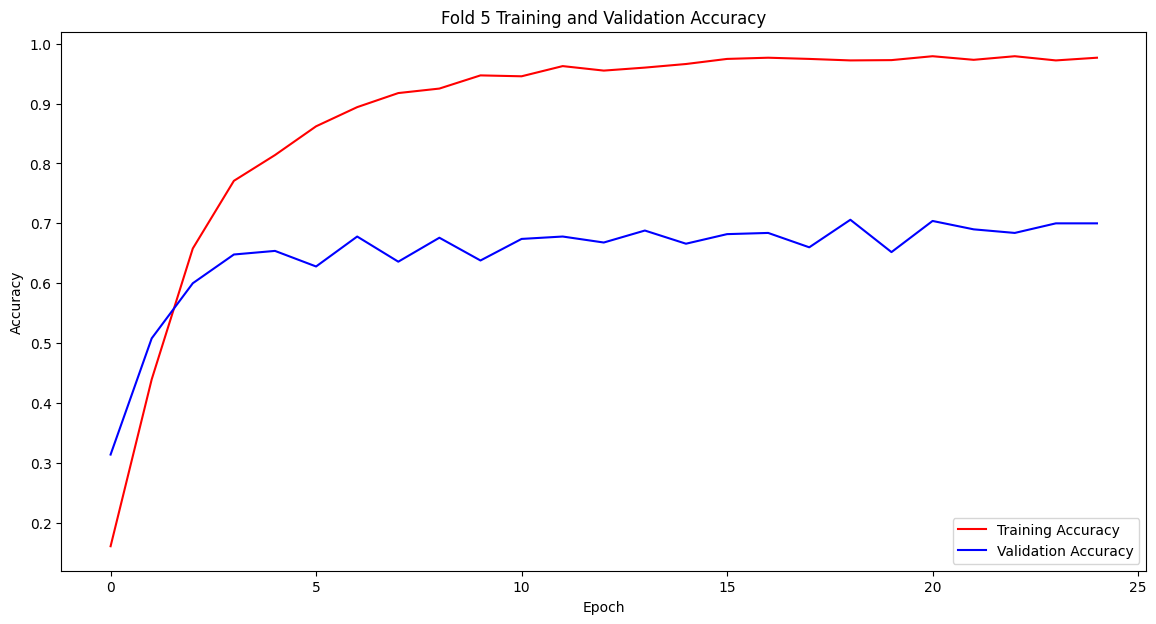

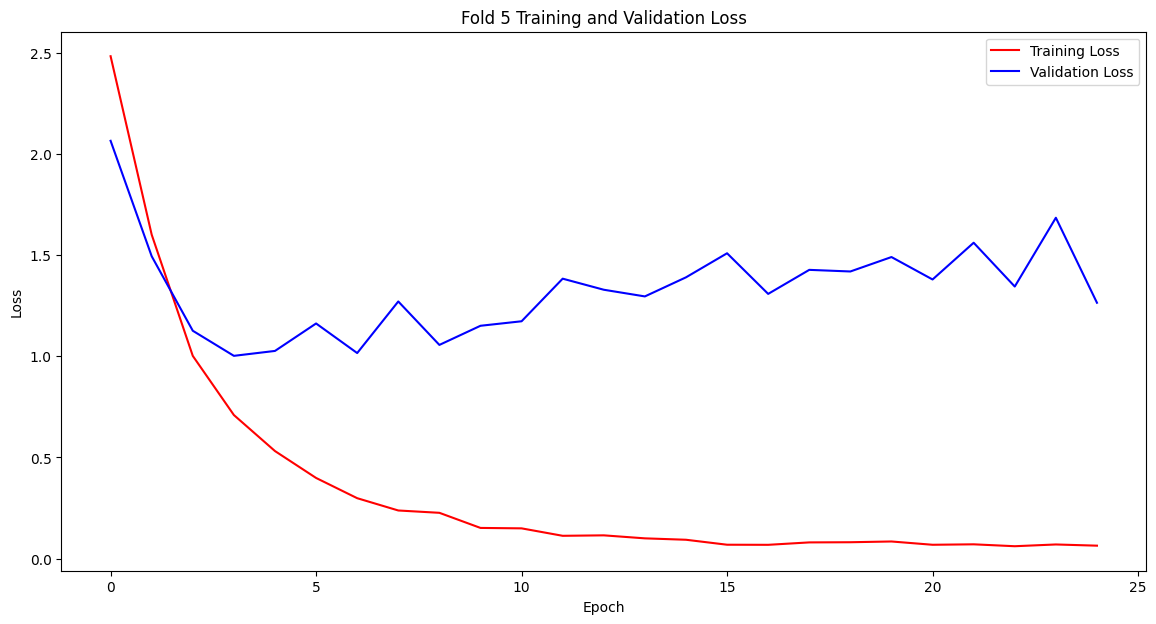

Score for fold 5: loss of 1.264047384262085; compile_metrics of 69.9999988079071%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.282970666885376 - Accuracy: 69.19999718666077%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.5928934812545776 - Accuracy: 67.40000247955322%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.8580650091171265 - Accuracy: 62.40000128746033%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.951101541519165 - Accuracy: 62.40000128746033%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.264047384262085 - Accuracy: 69.9999988079071%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 66.28000020980835 (

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set up paths and parameters
base_path = 'E:/DATASET EXPERIMENT/Resize exp'
SIZE = 224
image_size = (SIZE, SIZE)
batch_size = 32
channels = 3
kernel = 4
stride = 1
pool = 2

# Function to create the model
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=kernel, strides=stride, padding='same', activation='relu', input_shape=(SIZE, SIZE, channels)))
    model.add(MaxPool2D(pool_size=pool, strides=2, padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=kernel, strides=stride, activation='relu', padding='same'))
    model.add(MaxPool2D(pool, 2, padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=kernel, strides=stride, activation='relu', padding='same'))
    model.add(MaxPool2D(pool, 2, padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(units=num_classes, activation='softmax'))

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    return model

# Load dataset to determine number of classes
datagen = ImageDataGenerator(rescale=1./255)
dummy_dataset = datagen.flow_from_directory(base_path, target_size=image_size, batch_size=batch_size, class_mode='categorical')
num_classes = len(dummy_dataset.class_indices)
labels = list(dummy_dataset.class_indices.keys())

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_per_fold = []
loss_per_fold = []
fold_no = 1

for train_index, test_index in kf.split(np.arange(len(dummy_dataset))):
    print(f'Fold {fold_no}')
    model = create_model()

    # Reinitialize data generators for each fold
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_set = train_datagen.flow_from_directory(
        base_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_set = val_datagen.flow_from_directory(
        base_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    history = model.fit(
        train_set,
        epochs=25,
        validation_data=val_set
    )

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig = plt.figure(figsize=(14, 7))
    plt.plot(acc, 'r', label="Training Accuracy")
    plt.plot(val_acc, 'b', label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Fold {fold_no} Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    fig = plt.figure(figsize=(14, 7))
    plt.plot(loss, 'r', label="Training Loss")
    plt.plot(val_loss, 'b', label="Validation Loss")
    plt.legend(loc='upper right')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold_no} Training and Validation Loss')
    plt.show()

    scores = model.evaluate(val_set, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1
# Assuming accuracy_per_fold and loss_per_fold contain the metrics for each fold
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
